# Hypothesis Testing

Exploring the data from the NSFG, we saw several "apparent effects," including differences between first babies and others.
So far we have taken these effects at face value; in this chapter, we put them to the test.

The fundamental question we want to address is whether the effects we see in a sample are likely to appear in the larger population.
For example, in the NSFG sample we see a difference in mean pregnancy length for first babies and others.
We would like to know if that effect reflects a real difference for women in the U.S., or if it might appear in the sample by chance.

There are several ways we could formulate this question, including Fisher null hypothesis testing, Neyman-Pearson decision theory, and Bayesian inference.
What I present here is a subset of all three that makes up most of what people use in practice, which I will call **classical hypothesis testing**.

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

<IPython.core.display.Javascript object>

In [4]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

<IPython.core.display.Javascript object>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

<IPython.core.display.Javascript object>

## Flipping Coins

We'll start with a simple example.
When Euro coins were introduced in 2002, a curious coin enthusiast spun a Belgian one-Euro coin on edge 250 times and noted that it landed with the heads side up 140 times and tails side up 110 times.
If the coin is perfectly balanced, we expect only 125 heads, so this data suggests the coin is biased.
On the other hand, we don't expect to get exactly 125 heads every time, so it's possible that the coin is actually fair, and the apparent excess of heads is due to chance.
To see whether that's plausible, we can perform a hypothesis test.

We'll use the following function to compute the excess number of heads, which is the difference between the observed number and the expected number if the coin is fair.

In [6]:
n = 250
p = 0.5


def excess_heads(heads):
    expected = n * p
    return heads - expected

<IPython.core.display.Javascript object>

In the observed data, the number of excess heads is 15.

In [7]:
heads = 140
tails = 110

observed_stat = excess_heads(heads)
observed_stat

15.0

<IPython.core.display.Javascript object>

If the coin is actually fair, we can simulate the coin-spinning experiment by generating a sequence of random strings -- either `'H'` or `'T'` with equal probability -- and counting the number of times `'H'` appears.

In [8]:
def simulate_flips():
    flips = np.random.choice(["H", "T"], size=n)
    heads = np.sum(flips == "H")
    return heads

<IPython.core.display.Javascript object>

Each time we call this function, we get the outcome of a simulated experiment.

In [9]:
np.random.seed(1)

<IPython.core.display.Javascript object>

In [10]:
simulate_flips()

119

<IPython.core.display.Javascript object>

The following loop simulates the experiment many times and computes the number of excess heads for each one.

In [11]:
simulated_stats = [excess_heads(simulate_flips()) for i in range(10001)]

<IPython.core.display.Javascript object>

The result is a sample from the distribution of excess heads under the assumption that the coin is fair.
Here's what the distribution of these values looks like.

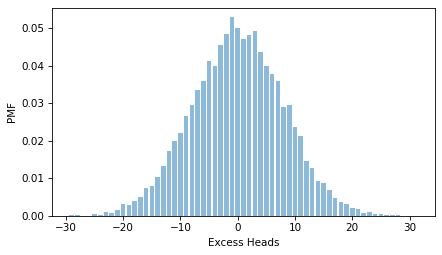

<IPython.core.display.Javascript object>

In [12]:
from empiricaldist import Pmf

pmf_effects = Pmf.from_seq(simulated_stats)
pmf_effects.bar(alpha=0.5)

decorate(xlabel="Excess Heads", ylabel="PMF")

Values near 0 are the most common.
Values greater than 10 and less than -10 are less common.
Remembering that in the observed data, there were 15 excess heads, we see that excesses of that magnitude are rare, but not impossible.
In this example, the simulated results exceed or equal 15 about 3.5% of the time.

In [13]:
(np.array(simulated_stats) >= 15).mean() * 100

3.5296470352964704

<IPython.core.display.Javascript object>

And about as often the number of excess heads is less than or equal to -15.

In [14]:
(np.array(simulated_stats) <= -15).mean() * 100

3.54964503549645

<IPython.core.display.Javascript object>

If the coin is fair, we expect the excess to be 15 or more 3.5% of the time, just by chance.
And we expect the the magnitude of the excess, in either direction, to be 15 or more about 7% of the time.

In conclusion, an apparent effect of this size is not common, but it is certainly not impossible, even if the coin is fair.
On the basis of this experiment, we can't rule out the possibility that the coin is fair.

This example demonstrates the logic of statistical hypothesis testing.

* We started with an observation, 140 heads out of 250 spins, and the hypothesis that the coin is biased -- that is, that the probability of heads is greater than 50%.

* We chose a **test statistic** that quantifies the size of the apparent effect. In this example, the test statistic is the number of excess heads.

* We defined a **null hypothesis**, which is a model based on the assumption that the apparent effect is due to chance. In this example, the null hypothesis is that the coin is fair.

* The third step is to compute a **p-value**, which is the probability of seeing the apparent effect if the null hypothesis is true. In this example, the p-value is the probability of 15 or more excess heads.

The last step is to interpret the result.
If the p-value is low, we can conclude that the effect would be unlikely to happen by chance.
In this example, the p-value is either 3.5% or 7%, depending on how we define the effect.
So the effect is unlikely to happen by chance, but we can't rule out the possibility.

All hypothesis tests are based on these elements -- a test statistic, a null hypothesis, and a p-value.

## Testing a Difference in Means

In the NSFG data, we saw that the average pregnancy length for first babies is slightly longer than for other babies.
Now let's see if that difference could be due to chance.



The following cells download the data and install `statadict`, which we need to read the data.

In [15]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

<IPython.core.display.Javascript object>

In [ ]:
try:
    import statadict
except ImportError:
    !pip install statadict

The function `get_nsfg_groups` reads the data, selects live births, and groups live births into first babies and others.

In [17]:
from nsfg import get_nsfg_groups

live, firsts, others = get_nsfg_groups()

<IPython.core.display.Javascript object>

Now we can select pregnancy lengths, in weeks, for both groups.

In [18]:
data = firsts["prglngth"].values, others["prglngth"].values

<IPython.core.display.Javascript object>

The following function takes the data, as a tuple of two sequences, and computes the difference in means. 

In [19]:
def diff_means(data):
    group1, group2 = data
    diff = np.mean(group1) - np.mean(group2)
    return np.abs(diff)

<IPython.core.display.Javascript object>

The average pregnancy length is 0.078 weeks longer for first babies.

In [20]:
observed_diff = diff_means(data)
observed_diff

0.07803726677754952

<IPython.core.display.Javascript object>

So the hypothesis we'll test is whether pregnancy length is generally longer for first babies.
The null hypothesis is that pregnancy lengths are actually the same for both groups, and the apparent difference is due to chance.
If pregnancy lengths are the same for both groups, we can combine the two groups into a single pool.

In [21]:
pool = np.hstack(data)
len(pool)

9148

<IPython.core.display.Javascript object>

Now to simulate the experiment, we can shuffle the pool and divide it into two groups with the same sizes as the original.

In [22]:
def simulate_groups(data):
    group1, group2 = data
    n, m = len(group1), len(group2)

    np.random.shuffle(pool)
    return pool[:n], pool[-m:]

<IPython.core.display.Javascript object>

Each time we call this function, it returns a tuple of sequences, which we can pass to `diff_means`.

In [23]:
diff_means(simulate_groups(data))

0.031193045602279312

<IPython.core.display.Javascript object>

The following loop simulated the experiment many times and computes the difference in means for each simulated dataset.

In [24]:
simulated_diffs = [diff_means(simulate_groups(data)) for i in range(1001)]

<IPython.core.display.Javascript object>

To visualize the results, we'll use the following function, which takes a sample of simulated results and makes a `Pmf` object that approximates its distribution.

In [25]:
from scipy.stats import gaussian_kde
from empiricaldist import Pmf


def make_pmf(sample, low, high):
    kde = gaussian_kde(sample)
    qs = np.linspace(low, high, 201)
    ps = kde(qs)
    return Pmf(ps, qs)

<IPython.core.display.Javascript object>

We'll also use this function, which fills in the tail of the distribution.

In [26]:
from thinkstats import underride


def fill_tail(pmf, observed, side, **options):
    """Fill the area under a PMF, right or left of an observed value."""
    options = underride(options, alpha=0.3)

    if side == "right":
        condition = pmf.qs >= observed
    elif side == "left":
        condition = pmf.qs <= observed

    series = pmf[condition]
    plt.fill_between(series.index, 0, series, **options)

<IPython.core.display.Javascript object>

Here's what the distribution of the simulated results looks like.
The shaded region shows the cases where the difference in means under the null hypothesis exceeds the observed difference.
The area of this region is the p-value.

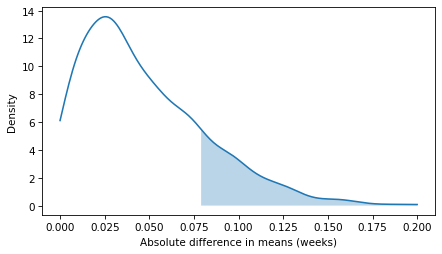

<IPython.core.display.Javascript object>

In [27]:
pmf = make_pmf(simulated_diffs, 0, 0.2)
pmf.plot()
fill_tail(pmf, observed_diff, "right")
decorate(xlabel="Absolute difference in means (weeks)", ylabel="Density")

The following function computes the p-value, which is the fraction of simulated values that are as big or bigger than the observed value.

In [28]:
def compute_p_value(simulated, observed):
    """Fraction of simulated values as big or bigger than the observed value."""
    return (np.asarray(simulated) >= observed).mean()

<IPython.core.display.Javascript object>

In this example, the p-value is about 17%, which means it is plausible that a difference as big as 0.078 weeks could happen by chance.

In [29]:
compute_p_value(simulated_diffs, observed_diff)

0.17582417582417584

<IPython.core.display.Javascript object>

Based on this result, we can't be sure that pregnancy lengths are generally longer for first babies -- it's possible that the difference in this dataset is due to chance.

Notice that we've seen the same elements in both examples of hypothesis testing.
In this example, the test statistic is the difference in the means.
The null hypothesis is that the distribution of pregnancy lengths is actually the same in both groups.
We modeled the null hypothesis by combining the data from both groups into a single pool, shuffling the pool, and splitting it into two groups with the same sizes as the originals.
This process is called **permutation**, which is another word for shuffling.

A strength of this computational approach to hypothesis testing is that we can combine these elements to test different statistics.

## Other Test Statistics

We might wonder whether pregnancy lengths for first babies are not just longer, but maybe more variable.
To test that hypothesis, we can use as a test statistic the difference between the standard deviations of the two groups.
The following function computes this test statistic.

In [30]:
def diff_stds(data):
    group1, group2 = data
    diff = np.std(group1) - np.std(group2)
    return np.abs(diff)

<IPython.core.display.Javascript object>

In the NSFG dataset, the difference in standard deviations is about 0.18, pregnancy lengths for first babies are apparently more variable.

In [31]:
observed_diff = diff_stds(data)
observed_diff

0.17600895913991677

<IPython.core.display.Javascript object>

To see whether this difference might be due to chance, we can use permutation again.
The following loop simulates the null hypothesis many times and computes the difference in standard deviation for each simulated dataset.

In [32]:
simulated_diffs = [diff_stds(simulate_groups(data)) for i in range(1001)]

<IPython.core.display.Javascript object>

Here's what the distribution of the results looks like.
Again, the shaded region shows where the test statistic under the null hypothesis exceeds the observed difference.

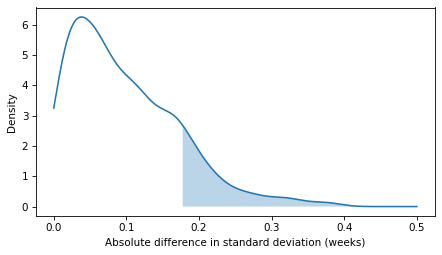

<IPython.core.display.Javascript object>

In [33]:
pmf = make_pmf(simulated_diffs, 0, 0.5)
pmf.plot()
fill_tail(pmf, observed_diff, "right")
decorate(xlabel="Absolute difference in standard deviation (weeks)", ylabel="Density")

We can estimate the area of this region by computing the fraction of results that are as big or bigger than the observed difference.

In [34]:
compute_p_value(simulated_diffs, observed_diff)

0.14285714285714285

<IPython.core.display.Javascript object>

Again, it is plausible that we could see a difference this big even if the two groups are the same.
So we can't be sure that pregnancy lengths are generally more variable for first babies -- the difference we see in this dataset could be due to chance.

## Testing a Correlation

We can use the same framework to test correlations.
For example, in the NSFG data set, there is a correlation between birth weight and mother's age -- older mothers have heavier babies, on average.
But could this apparent effect be due to chance?

To find out, we'll start by preparing the data.
From live births, we'll select cases where the age of the mother and birth weight are known.

In [35]:
valid = live.dropna(subset=["agepreg", "totalwgt_lb"])
valid.shape

(9038, 244)

<IPython.core.display.Javascript object>

Then we'll select the relevant columns.

In [41]:
ages = valid["agepreg"]
birthweights = valid["totalwgt_lb"]

<IPython.core.display.Javascript object>

The following function takes a tuple of `xs` and `ys` and computes the magnitude of the correlation, positive or negative.

In [38]:
def abs_correlation(data):
    xs, ys = data
    corr = np.corrcoef(xs, ys)[0, 1]
    return np.abs(corr)

<IPython.core.display.Javascript object>

In the NSFG dataset, the correlation is about 0.07.

In [43]:
data = ages, birthweights
observed_corr = abs_correlation(data)
observed_corr

0.0688339703541091

<IPython.core.display.Javascript object>

The null hypothesis is that there is no correlation between mother's age and birth weight.
By shuffling the observed values, we can simulate a world where the distributions of age and birth weight are the same, but where the variables are unrelated.

The following function takes a tuple of `xs` and `ys`, shuffles `xs` and returns a tuple containing the shuffled `xs` and the original `ys`.
We could have shuffle the `ys` instead, or shuffled both.
Any of those variations would work just as well.

In [ ]:
def permute(data):
    xs, ys = data
    new_xs = xs.values.copy()
    np.random.shuffle(new_xs)
    return new_xs, ys

The correlation of the shuffled values is usually close to 0.

In [ ]:
abs_correlation(permute(data))

The following loop generates many shuffled datasets and computes the correlation of each one.

In [ ]:
simulated_corrs = [abs_correlation(permute(data)) for i in range(1001)]

Here's what the distribution of the results looks like.
The vertical dotted line shows the observed correlation.

In [ ]:
pmf = make_pmf(simulated_corrs, 0, 0.07)
pmf.plot()
plt.axvline(observed_corr, ls=":")
decorate(xlabel="Correlation", ylabel="Density")

We can see that the observed correlation is in the tail of the distribution, with no visible area under the curve.
If we try to compute a p-value, the result is 0, indicating that the correlation in the shuffled data did not exceed the observed value in any of the simulations.

In [ ]:
compute_p_value(simulated_corrs, observed_corr)

The actual p-value is not exactly zero -- it is possible for the correlation of the shuffled data to exceed the observed value -- but it is very unlikely.

When the p-value is small, traditionally less than 0.05, we can say that the result is **statistically significant**.
But this way of interpreting p-values has always been problematic, and it is slowly becoming less widely used.

One problem is that the traditional threshold is arbitrary and not appropriate for all applications.
Another problem is that this use of "significant" is misleading because it suggests that the effect is important in practice.
The correlation between mother's age and birth weight is a good example -- it is statistically significant, but so small that it is not important.

An alternative is to interpret p-values qualitatively.

* If a p-value is large, it is plausible that the apparent effect could happen by chance.

* If the p-value is small, we can often rule out the possibility that the effect is due to chance -- but we should remember that it could still be due to non-representative sampling or measurement errors.


## Testing Proportions

As a final example, let's consider a case where the choice of the test statistic takes some thought.
Suppose you run a casino and you suspect that a customer is using a crooked die -- that is, one that has been modified to make one of the faces more likely than the others.
You apprehend the alleged cheater and confiscate the die, but now you have to prove that it is crooked.
You roll the die 60 times and record the frequency of each outcome from 1 to 6.
Here are the results in a `Hist` object.

In [ ]:
from empiricaldist import Hist

qs = np.arange(1, 7)
freqs = [8, 9, 19, 5, 8, 11]
observed = Hist(freqs, qs)
observed.index.name = "outcome"
observed

On average you expect each value to appear 10 times.
In this dataset, the value 3 appears more often than expected, and the value 4 appears less often.
But could these differences happen by chance?

To test this hypothesis, we'll use the following function to compute the expected frequency for each value, the difference between the expected and observed frequencies, and the total of the absolute differences.

In [ ]:
def total_deviation(observed):
    n = observed.sum()
    outcomes = observed.qs
    expected = Hist(n / 6, outcomes)
    return sum(abs(observed - expected))

In the observed dataset, the sum of the absolute difference is 20.

In [ ]:
observed_dev = total_deviation(observed)
observed_dev

The following function takes the observed data, simulates rolling a fair die the same number of times, and returns a `Hist` object that contains the simulated frequencies.

In [ ]:
def simulate_dice(observed):
    n = np.sum(observed)
    rolls = np.random.choice(observed.qs, n, replace=True)
    hist = Hist.from_seq(rolls)
    return hist

The following loop simulates the experiment many times and computes to total absolute deviation for each one.

In [ ]:
simulated_devs = [total_deviation(simulate_dice(observed)) for i in range(1001)]

Here's what the distribution of the total deviations looks like.
Notice that the total is always even, because every time an outcome appears more often than expected, another outcome has to appear less often.

In [ ]:
pmf_devs = Pmf.from_seq(simulated_devs)
pmf_devs.bar(alpha=0.5)

decorate(xlabel="Total absolute deviation", ylabel="PMF")

We can see that a total deviation of 20 is not unusual.
And the p-value is about 13%, which means that we can't be sure the die is crooked.

In [ ]:
compute_p_value(simulated_devs, observed_dev)

But the test statistic we chose was not the only option.
For a problem like this, it would be more conventional to use the chi-squared statistic, which we can compute like this.

In [ ]:
def chi_squared_stat(observed):
    n = observed.sum()
    outcomes = observed.qs
    expected = Hist(n / 6, outcomes)
    diffs = (observed - expected) ** 2
    return sum((observed - expected) ** 2 / expected)

Squaring the deviations (rather than taking absolute values) gives more weight to large deviations.
Dividing through by `expected` standardizes the deviations, although in this case it has no effect on the results because the expected frequencies are all equal.

In [ ]:
observed_chi_squared = chi_squared_stat(observed)
observed_chi_squared

The chi-squared statistic of the observed data is 11.6.
By itself, this number doesn't mean very much, but we can compare it to the results from the simulated rolls.
The following loop generates many simulated datasets and computes the chi-squared statistic for each one.

In [ ]:
simulated_chi_squared = [chi_squared_stat(simulate_dice(observed)) for i in range(1001)]

Here's what the distribution of the chi-squared statistic looks like under the null hypothesis.
The shaded region shows the results that exceed the observed test statistic.

In [ ]:
pmf = make_pmf(simulated_chi_squared, 0, 20)
pmf.plot()
fill_tail(pmf, observed_chi_squared, "right")
decorate(xlabel="Chi-Squared Statistic", ylabel="Density")

The area of the shaded region is the p-value.

In [ ]:
compute_p_value(simulated_chi_squared, observed_chi_squared)

The p-value using the chi-squared statistic is about 0.04, substantially smaller than what we got using total deviation, 0.13. If we take the 5% threshold seriously, we would consider this effect statistically significant.
But considering the two tests together, I would say that the results are borderline.
I would not rule out the possibility that the die is crooked, but I would not convict the accused cheater.

This example demonstrates an important point: the p-value depends on the choice of test statistic and the model of the null hypothesis, and sometimes these choices determine whether an effect is statistically significant or not.

## Glossary

-   **hypothesis testing**: The process of determining whether an apparent effect is statistically significant.

-   **test statistic**: A statistic used to quantify an effect size.

-   **null hypothesis**: A model of a system based on the assumption that an apparent effect is due to chance.

-   **p-value**: The probability that an effect could occur by chance.

-   **statistically significant**: An effect is statistically significant if it is unlikely to occur by chance.

-   **permutation test**: A way to compute p-values by generating permutations of an observed dataset.

-   **resampling test**: A way to compute p-values by generating samples, with replacement, from an observed dataset.

-   **two-sided test**: A test that asks, "What is the chance of an effect as big as the observed effect, positive or negative?"

-   **one-sided test**: A test that asks, "What is the chance of an effect as big as the observed effect, and with the same sign?"

-   **chi-squared test**: A test that uses the chi-squared statistic as the test statistic.

## Exercises

### Exercise

NOTE: This exercise and the next use different models of the same scenario, and I will suggest that the second is probably a better choice. I think the first is a good exercise, but the results might be misleading.

Returning to the skeet shooting example from Chapter 5.
In the 2020 Summer Olympics, 20 competitors participated in the preliminaries, but only the top 6 qualified for the finals.

During the preliminaries, each contestant shot 5 rounds of 25 targets each.
On average, the 6 qualifiers hit 24.57 out of 25 targets; the competitors who were eliminated hit 23.65 out of 25.
Let's see if that difference between the two groups is likely to reflect a real difference in ability, or whether it could have happened by chance.

The following cells download the data and read it into a `DataFrame`.

In [ ]:
filename = "Shooting_at_the_2020_Summer_Olympics_Mens_skeet"
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/" + filename)

In [ ]:
tables = pd.read_html(filename)
table = tables[6]
table

We can select the top 6 competitors and the rest like this.

In [ ]:
qualified = table.query("Rank <= 6")
eliminated = table.query("Rank > 6")

And here's how we can extract the results for each round, for each competitor, and flatten them into a sequence.

In [ ]:
columns = ["1", "2", "3", "4", "5"]
results_qualified = qualified[columns].values.flatten()
np.mean(results_qualified)

In [ ]:
results_eliminated = eliminated[columns].values.flatten()
np.mean(results_eliminated)

Use `diff_means` and `simulate_groups` to generate a large number of simulated datasets under the null hypothesis that the two groups have the same chance of hitting a target, and compute the difference in means for each one.
Compare the simulation results to the observed difference and compute a p-value.
Is it plausible that the difference between the groups happened by chance?

In [ ]:
data = results_qualified, results_eliminated
observed_diff = diff_means(data)
observed_diff

In [ ]:
pool = np.hstack(data)
len(pool)

In [ ]:
simulated_diffs = [diff_means(simulate_groups(data)) for i in range(1001)]

In [ ]:
pmf = make_pmf(simulated_diffs, 0, 1.25)
pmf.plot()
plt.axvline(observed_diff, ls=":")
decorate(xlabel="Difference in means", ylabel="Density")

In [ ]:
compute_p_value(simulated_diffs, observed_diff)

## Exercise

The result of the previous exercise might be misleading because...

In [ ]:
results = table[columns].values.flatten()

In [ ]:
n = 25
p = np.mean(results / 25)
p

In [ ]:
from scipy.stats import binom

simulated_data = binom.rvs(n, p, size=table[columns].shape)
simulated_results = pd.DataFrame(simulated_data, columns=columns)
simulated_results["Total"] = simulated_data.sum(axis=1)
simulated_results["Rank"] = simulated_results["Total"].rank(
    method="first", ascending=False
)
simulated_results

In [ ]:
qualified = simulated_results.query("Rank <= 6")
eliminated = simulated_results.query("Rank > 6")

In [ ]:
results_qualified = qualified[columns].values.flatten()
results_eliminated = eliminated[columns].values.flatten()
np.mean(results_qualified), np.mean(results_eliminated)